# Import Libraries

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.util import trigrams
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import ssl

In [2]:
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('vader_lexicon')
nltk.download("wordnet")
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/lenguyen/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/lenguyen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/lenguyen/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/lenguyen/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Import Data

Project Gutenberg: https://www.gutenberg.org/


We load in the texts Alice in Wonderland, Moby Dick, and Romeo and Juliet

In [3]:
aliceData = np.loadtxt('AliceInWonderland.txt', delimiter = "\n",  dtype = str)
mobyData = np.loadtxt('MobyDick.txt', delimiter = "\n",  dtype = str)
romeoData = np.loadtxt('RomeoAndJuliet.txt', delimiter = "\n",  dtype = str)

In [4]:
#look at our data
aliceData[55:65]

array(['large rabbit-hole under the hedge.',
       'In another moment down went Alice after it, never once considering how',
       'in the world she was to get out again.',
       'The rabbit-hole went straight on like a tunnel for some way, and then',
       'dipped suddenly down, so suddenly that Alice had not a moment to think',
       'about stopping herself before she found herself falling down a very',
       'deep well.',
       'Either the well was very deep, or she fell very slowly, for she had',
       'plenty of time as she went down to look about her and to wonder what',
       'was going to happen next. First, she tried to look down and make out'],
      dtype='<U82')

# Clean Data

## Tokenize

First we must tokenize the data, which means we need to take it out of long string sentance format into individual words which will be our tokens

In [44]:
tokenAlice = [re.sub(r'[^\w]', ' ', i).strip().split(" ") for i in aliceData]
tokenMoby = [re.sub(r'[^\w]', ' ', i).strip().split(" ") for i in mobyData]
tokenRomeo = [re.sub(r'[^\w]', ' ', i).strip().split(" ") for i in romeoData]

## Stop Word Removal

Next, we remove articles in our sentences, such as "is", "and", "the" - they will not me helpful in our analysis 

In [7]:
stopwords.words("english")

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [8]:
cleanAlice = []
cleanMoby = []
cleanRomeo = []

for sentence in tokenAlice:
    cleanAlice.append([i.lower() for i in sentence if i.lower() not in stopwords.words("english")])
    
for sentence in tokenMoby:
    cleanMoby.append([i.lower() for i in sentence if i.lower() not in stopwords.words("english")])

for sentence in tokenRomeo:
    cleanRomeo.append([i.lower() for i in sentence if i.lower() not in stopwords.words("english")])
    

In [9]:
cleanAlice[55:65]

[['large', 'rabbit', 'hole', 'hedge'],
 ['another', 'moment', 'went', 'alice', '', 'never', 'considering'],
 ['world', 'get'],
 ['rabbit', 'hole', 'went', 'straight', 'like', 'tunnel', 'way', ''],
 ['dipped', 'suddenly', '', 'suddenly', 'alice', 'moment', 'think'],
 ['stopping', 'found', 'falling'],
 ['deep', 'well'],
 ['either', 'well', 'deep', '', 'fell', 'slowly', ''],
 ['plenty', 'time', 'went', 'look', 'wonder'],
 ['going', 'happen', 'next', '', 'first', '', 'tried', 'look', 'make']]

## Lemmatization and Stemming

Lemmatization and Stemming are both methods of removing prefixes and suffixes from words. Stemming is the most brute force and removes the prefix/suffix while Lemmatization replaces the word with the root word.

In [10]:
lemmatizer = WordNetLemmatizer()

print("Stemming:")
print("studies:", PorterStemmer().stem("studies") + "\n")
print("Lemmatization")
print("studies:", lemmatizer.lemmatize("studies"))

Stemming:
studies: studi

Lemmatization
studies: study


In [11]:
lemmaAlice = []
lemmaMoby = []
lemmaRomeo = []

for sentence in cleanAlice:
    lemmaAlice.append([lemmatizer.lemmatize(i) for i in sentence])
    
for sentence in cleanMoby:
    lemmaMoby.append([lemmatizer.lemmatize(i) for i in sentence])

for sentence in cleanRomeo:
    lemmaRomeo.append([lemmatizer.lemmatize(i) for i in sentence])
    

# Analysis

## Term Frequency

In [12]:
def getWordCount(words):
    word_count = {}
    for word in words:
        if word not in word_count:
            word_count[word] = 1
        elif word in word_count:
            word_count[word] += 1
    word_count.pop('')
    return sorted(word_count.items(), key=lambda x: x[1], reverse=True)

In [13]:
tfAlice = getWordCount(np.concatenate(lemmaAlice))
tfMoby = getWordCount(np.concatenate(lemmaMoby))
tfRomeo = getWordCount(np.concatenate(lemmaRomeo))

In [14]:
tfAlice[0:10]

[('said', 460),
 ('alice', 402),
 ('little', 127),
 ('one', 104),
 ('gutenberg', 98),
 ('know', 90),
 ('project', 88),
 ('like', 86),
 ('work', 86),
 ('went', 83)]

In [15]:
tfMoby[0:10]

[('whale', 1500),
 ('one', 943),
 ('like', 650),
 ('ship', 607),
 ('upon', 568),
 ('sea', 542),
 ('man', 527),
 ('ahab', 513),
 ('boat', 481),
 ('ye', 472)]

In [16]:
tfRomeo[0:10]

[('romeo', 320),
 ('thou', 278),
 ('juliet', 193),
 ('thy', 170),
 ('capulet', 163),
 ('love', 154),
 ('nurse', 148),
 ('thee', 138),
 ('come', 123),
 ('lady', 122)]

## Part of Speech Tagging

Look up all part of speech tags in NLTK: https://www.guru99.com/pos-tagging-chunking-nltk.html

In [17]:
mobyTags = nltk.pos_tag([i[0] for i in tfMoby])

In [18]:
#sort by most used verb
[i for i in mobyTags if i[-1] == "VB"][0:10]

[('though', 'VB'),
 ('say', 'VB'),
 ('queequeg', 'VB'),
 ('round', 'VB'),
 ('go', 'VB'),
 ('good', 'VB'),
 ('god', 'VB'),
 ('know', 'VB'),
 ('take', 'VB'),
 ('let', 'VB')]

## Sentiment Analysis

In [19]:
analyzer = SentimentIntensityAnalyzer()

In [20]:
print("kill: ",analyzer.polarity_scores("kill"))
print("love: ",analyzer.polarity_scores("love"))
print("spoon: ",analyzer.polarity_scores("spoon"))

kill:  {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.6908}
love:  {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.6369}
spoon:  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


In [21]:
aliceSentiment = []
mobySentiment = []
romeoSentiment = []

for i in lemmaAlice:
     aliceSentiment.append(analyzer.polarity_scores(" ".join(i))['compound'])
        
for i in lemmaMoby:
    mobySentiment.append(analyzer.polarity_scores(" ".join(i))['compound'])
        
for i in lemmaRomeo:
    romeoSentiment.append(analyzer.polarity_scores(" ".join(i))['compound'])
        


In [22]:
print("Most Positve")
print(romeoData[romeoSentiment.index(max(romeoSentiment))] + "\n")
print("Most Negative")
print(romeoData[romeoSentiment.index(min(romeoSentiment))])

Most Positve
Doth grace for grace and love for love allow.

Most Negative
Alack the day, she’s dead, she’s dead, she’s dead!


# Modeling

## Embeddings

Embeddings allow us to translate words and sentences into numerical vectors for use. There are many embedding methods to use with the best capturing the contextual and semantic meaning of words

https://medium.com/sfu-cspmp/nlp-word-embedding-techniques-for-text-analysis-ec4e91bb886f


In [23]:
def joinString(data):
    string = []
    for i in data:
        string.append(" ".join(i))
    return string

In [24]:
#Simple embedding
vectorizer = CountVectorizer()

In [47]:
vectorAlice = vectorizer.fit_transform(lemmaAlice[55])
print(lemmaAlice[55])
print(vectorAlice.toarray())

['large', 'rabbit', 'hole', 'hedge']
[[0 0 1 0]
 [0 0 0 1]
 [0 1 0 0]
 [1 0 0 0]]


In [56]:
vectorAlice = vectorizer.fit_transform(joinString(lemmaAlice))
vectorMoby = vectorizer.fit_transform(joinString(lemmaMoby))
vectorRomeo = vectorizer.fit_transform(joinString(lemmaRomeo))
vectorAll = vectorizer.fit_transform(joinString(np.concatenate([lemmaAlice,lemmaMoby,lemmaRomeo])))

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [61]:
index = np.zeros(len(vectorAll.toarray()))
index[len(lemmaAlice):len(lemmaAlice) + len(lemmaMoby)] = 1
index[len(lemmaAlice) + len(lemmaMoby):] = 2


## Clustering

In [85]:
pca = PCA(n_components=2)
pcaVectors = pca.fit_transform(vectorAlice.todense())

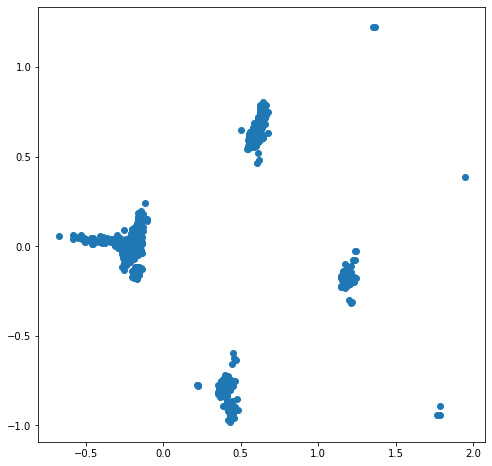

In [86]:
plt.figure(figsize = (8,8))
plt.scatter(pcaVectors[:,0],pcaVectors[:,1])


In [96]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(pcaVectors)

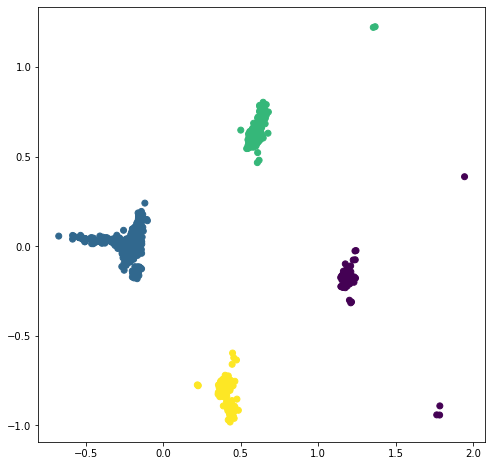

In [97]:
plt.figure(figsize = (8,8))
plt.scatter(pcaVectors[:,0],pcaVectors[:,1], c = kmeans.labels_ )


In [99]:
aliceData[kmeans.labels_ == 0]

array(['before,” said Alice,) and round the neck of the bottle was a paper',
       '“What a curious feeling!” said Alice; “I must be shutting up like a',
       'said Alice to herself, “in my going out altogether, like a candle. I',
       '“Come, there’s no use in crying like that!” said Alice to herself,',
       '“You ought to be ashamed of yourself,” said Alice, “a great girl like',
       '“I’m sure those are not the right words,” said poor Alice, and her eyes',
       '“That _was_ a narrow escape!” said Alice, a good deal frightened at the',
       'railway,” she said to herself. (Alice had been to the seaside once in',
       '“I wish I hadn’t cried so much!” said Alice, as she swam about, trying',
       '“Well, perhaps not,” said Alice in a soothing tone: “don’t be angry',
       '“I won’t indeed!” said Alice, in a great hurry to change the subject of',
       'was quite pale (with passion, Alice thought), and it said in a low',
       '“As wet as ever,” said Alice in a melan